In [1]:
import sys
sys.path.append('..')
import tedq as qai

# Related package
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

# Hamiltonian related
from openfermion.chem import MolecularData
import openfermion
from openfermionpyscf import run_pyscf

# MISC
r_bohr = 0.529177210903

# Global variable
n_qubits = 4

# 
tolerance = 1e-6
min_pass = 5

# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
n_points = 40
bond_length_interval = 3.0 / n_points

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
def Rot(alpha, beta, theta, qubit):
    qai.RX(alpha, qubits=[qubit])
    qai.RY(beta, qubits=[qubit])
    qai.RZ(theta, qubits=[qubit])
# Ansatz
def ansatz(params):
    for i in range(n_qubits):
        Rot(params[i][0], params[i][1], params[i][2], i)
    for j in range(n_qubits-1, -1, -1):
        for k in range(j+1, n_qubits):
            qai.CNOT(qubits=(j, k))

In [3]:
# Hamiltonian


def get_H2_hamiltonian(distance):
    bond_length=distance*r_bohr
    geometry = [('H', (0., 0., -bond_length/2)), ('H', (0., 0., bond_length/2))]
    molecule = MolecularData(
        geometry, basis, multiplicity,charge=0,
        description=str(round(bond_length, 2)))
    molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
    terms_molecular_hamiltonian = molecule.get_molecular_hamiltonian(occupied_indices=[], active_indices=[0,1])
    fermionic_hamiltonian = openfermion.transforms.get_fermion_operator(terms_molecular_hamiltonian)
    jw_hamiltonian = openfermion.transforms.jordan_wigner(fermionic_hamiltonian)
#     print(jw_hamiltonian.terms)
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.fci_energy))

    return jw_hamiltonian.terms, molecule.fci_energy


In [4]:

def getGateFromName(name):
    if name=="I":
        return qai.I
    if name=="X":
        return qai.PauliX
    if name=="Y":
        return qai.PauliY
    if name=="Z":
        return qai.PauliZ
def measurements(gatesPrefix):
    gateList = []
    for qubit, gatePrefix in list(gatesPrefix):
        gate = getGateFromName(gatePrefix)
        gateList.append(gate(qubits=[qubit]))
    return gateList

def initCircuit(distance):
    H, fci_energy = get_H2_hamiltonian(distance)
    for idx in H:
        def circuitDef(params):
            ansatz(params)
            qai.measurement.expval(measurements(idx))
        circList.append(qai.Circuit(circuitDef, n_qubits, torch.zeros(n_qubits,3)))
        compiledCircList.append(circList[-1].compilecircuit('pytorch'))
        weightList.append(H[idx])
    return fci_energy


In [5]:
import torch.nn as nn

distList = np.arange(0.5,1.0, 0.5)
energyList = np.array([])
fciEnergyList = np.array([])
print(distList)
params = torch.ones(12, requires_grad=True)
# params = torch.rand(12, requires_grad=True)

time_start=time.time()    

timestamp = np.array([])
error = np.array([])

for distance in distList:
    circList = []
    compiledCircList = []
    weightList = []
    fciE = initCircuit(distance)
#     params = torch.ones(12, requires_grad=True)
#     params = torch.rand(12, requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=0.9)

    exp = last_exp = 10000
    count = 0
    for epoch in range(200):
        l_sum = 0

        loss = nn.L1Loss()
        x = torch.reshape(params, (4,3))
        psi_star = torch.conj(compiledCircList[0](x))
        exp = 0
        for idx, compiledCirc in enumerate(compiledCircList):   
#             H_psi = compiledCirc(x)
#             exp += torch.tensordot(psi_star[0],H_psi[0], dims=4).real*weightList[idx].real
            exp += compiledCirc(x).real*weightList[idx].real
            pass
        
        if epoch%5==0:
            print(epoch, exp.item())
            timestamp = np.append(timestamp, time.time()-time_start)
            error = np.append(error, exp.item()-fciE)
        if np.abs(exp.item()-last_exp)<tolerance:
            count+=1
            if count>min_pass:
                timestamp = np.append(timestamp, time.time()-time_start)
                error = np.append(error, exp.item()-fciE)
                break
        else:
            count = 0
        last_exp = exp.item()
        l = loss(exp, torch.Tensor([-100.]))
        l.backward()        
        optimizer.step()
        optimizer.zero_grad()
    print(params)
    energyList = np.append(energyList, exp.item())
    fciEnergyList = np.append(fciEnergyList, fciE)
time_end=time.time()

[0.5]
Hartree-Fock energy of -0.4033264416010218 Hartree.
Hartree-Fock energy of -0.41078847041741406 Hartree.
0 1.8715239763259888
5 1.6728017330169678
10 1.3911371231079102
15 1.3045921325683594
20 1.1498634815216064
25 -0.0196046382188797
30 -0.17463190853595734
35 -0.22249053418636322
40 -0.31167635321617126
45 -0.3666268587112427
50 -0.3891586363315582
55 -0.40181970596313477
60 -0.4026760458946228
65 -0.39774924516677856
70 -0.4041237235069275
75 -0.4068910479545593
80 -0.40911865234375
85 -0.4097751975059509
90 -0.41046595573425293
95 -0.41008269786834717
100 -0.4105347692966461
105 -0.4106913208961487
110 -0.41069525480270386
115 -0.41072604060173035
120 -0.41075465083122253
125 -0.4107755422592163
130 -0.4107724726200104
135 -0.41078460216522217
140 -0.4107827842235565
145 -0.4107861816883087
150 -0.4107877016067505
tensor([3.2199e+00, 5.0885e-02, 1.0000e+00, 3.1415e+00, 3.1415e+00, 1.0000e+00,
        3.1406e+00, 5.7634e-04, 1.0000e+00, 3.1423e+00, 3.1413e+00, 1.0000e+00],
  

time:  8.282965895


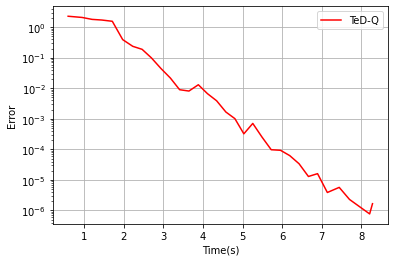

In [6]:
plt.plot(timestamp, error, 'r-', label="TeD-Q")
plt.xlabel('Time(s)')
plt.grid()
plt.ylabel('Error')
plt.gca().set_yscale('log')
plt.legend()
print("time: ", time_end-time_start)

In [7]:
distList = np.arange(0.5,3.5, 0.1)
energyList = np.array([])
fciEnergyList = np.array([])
print(distList)
params = torch.ones(12, requires_grad=True)
# params = torch.rand(12, requires_grad=True)

time_start=time.time()    


for distance in distList:
    time_epoch_start = time.time()
    circList = []
    compiledCircList = []
    weightList = []
    fciE = initCircuit(distance)
#     params = torch.ones(12, requires_grad=True)
#     params = torch.rand(12, requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=0.9)

    exp = last_exp = 10000
    count = 0
    for epoch in range(200):
        l_sum = 0

        loss = nn.L1Loss()
        x = torch.reshape(params, (4,3))
        psi_star = torch.conj(compiledCircList[0](x))
        exp = 0
        for idx, compiledCirc in enumerate(compiledCircList):   
#             H_psi = compiledCirc(x)
#             exp += torch.tensordot(psi_star[0],H_psi[0], dims=4).real*weightList[idx].real
            exp += compiledCirc(x).real*weightList[idx].real
            pass
        
        if epoch%5==0:
            print(epoch, exp.item())
        if np.abs(exp.item()-last_exp)<tolerance:
            count+=1
            if count>min_pass:
                break
        else:
            count = 0
        if time.time()-time_epoch_start>10:
            break
        last_exp = exp.item()
        l = loss(exp, torch.Tensor([-100.]))
        l.backward()        
        optimizer.step()
        optimizer.zero_grad()
    print(params)
    energyList = np.append(energyList, exp.item())
    fciEnergyList = np.append(fciEnergyList, fciE)
time_end=time.time()

[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4]
Hartree-Fock energy of -0.4033264416010218 Hartree.
Hartree-Fock energy of -0.41078847041741406 Hartree.
0 1.8715239763259888
5 1.6728017330169678
10 1.3911371231079102
15 1.3045921325683594
20 1.1498634815216064
25 -0.0196046382188797
30 -0.17463190853595734
35 -0.22249053418636322
40 -0.31167635321617126
45 -0.3666268587112427
50 -0.3891586363315582
55 -0.40181970596313477
60 -0.4026760458946228
65 -0.39774924516677856
70 -0.4041237235069275
75 -0.4068910479545593
80 -0.40911865234375
85 -0.4097751975059509
90 -0.41046595573425293
95 -0.41008269786834717
100 -0.4105347692966461
105 -0.4106913208961487
110 -0.41069525480270386
115 -0.41072604060173035
120 -0.41075465083122253
125 -0.4107755422592163
tensor([ 3.2199e+00,  4.9619e-02,  1.0000e+00,  3.1405e+00,  3.1405e+00,
         1.0000e+00,  3.1443e+00, -8.3439e-04,  1.0000e+00,  3.1437e+00,
         3.1450e+00, 

120 -1.1352260112762451
125 -1.1352280378341675
130 -1.1352274417877197
tensor([3.3133e+00, 1.1246e-01, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00,
        3.1410e+00, 6.3245e-04, 1.0000e+00, 9.4254e+00, 9.4254e+00, 1.0000e+00],
       requires_grad=True)
Hartree-Fock energy of -1.1167143250638318 Hartree.
Hartree-Fock energy of -1.1372759436172828 Hartree.
0 -1.137096643447876
5 -1.02109694480896
10 -1.0581220388412476
15 -1.0360584259033203
20 -1.0628224611282349
25 -1.1085145473480225
30 -1.1288931369781494
35 -1.1266117095947266
40 -1.129418969154358
45 -1.1355774402618408
50 -1.1345294713974
55 -1.1359953880310059
60 -1.1368221044540405
65 -1.1366153955459595
70 -1.1370904445648193
75 -1.1370213031768799
80 -1.1372008323669434
85 -1.1371912956237793
90 -1.1372451782226562
95 -1.1372528076171875
100 -1.137259840965271
105 -1.1372689008712769
110 -1.1372706890106201
115 -1.1372711658477783
120 -1.137274980545044
125 -1.1372755765914917
130 -1.1372753381729126
tensor([3.3318e+00,

Hartree-Fock energy of -0.999643227920801 Hartree.
Hartree-Fock energy of -1.0529584893385886 Hartree.
0 -1.052619218826294
5 -0.939717173576355
10 -0.9768900871276855
15 -1.0018823146820068
20 -1.0073654651641846
25 -1.0242499113082886
30 -1.0401424169540405
35 -1.0484399795532227
40 -1.0503851175308228
45 -1.0492781400680542
50 -1.0511070489883423
55 -1.0524550676345825
60 -1.052205204963684
65 -1.0525569915771484
70 -1.0528383255004883
75 -1.0527788400650024
80 -1.0529110431671143
85 -1.0528786182403564
90 -1.052951455116272
95 -1.0529327392578125
100 -1.0529488325119019
105 -1.0529547929763794
110 -1.0529530048370361
115 -1.0529571771621704
120 -1.05295729637146
tensor([ 3.5532e+00,  2.8449e-01,  1.0000e+00, -6.2840e+00,  6.2840e+00,
         1.0000e+00,  3.1425e+00, -9.3445e-04,  1.0000e+00,  1.5707e+01,
         1.5707e+01,  1.0000e+00], requires_grad=True)
Hartree-Fock energy of -0.9826993263215826 Hartree.
Hartree-Fock energy of -1.0414893384162593 Hartree.
0 -1.041159629821777

40 -0.9704902172088623
45 -0.971261203289032
50 -0.9704796075820923
55 -0.9711806178092957
60 -0.9718889594078064
65 -0.971798300743103
70 -0.9720065593719482
75 -0.9721043705940247
80 -0.9720569849014282
85 -0.972126841545105
90 -0.9721159338951111
95 -0.9721410274505615
100 -0.9721345901489258
105 -0.9721458554267883
110 -0.9721441268920898
115 -0.9721452593803406
120 -0.9721463918685913
125 -0.9721463322639465
tensor([ 3.8575e+00,  5.9292e-01,  1.0000e+00, -9.4249e+00,  3.1417e+00,
         1.0000e+00,  3.1420e+00, -3.9565e-04,  1.0000e+00,  1.8849e+01,
         2.5132e+01,  1.0000e+00], requires_grad=True)
Hartree-Fock energy of -0.8422970366437781 Hartree.
Hartree-Fock energy of -0.966692672976077 Hartree.
0 -0.96638023853302
5 -0.8735356330871582
10 -0.949273407459259
15 -0.9339436292648315
20 -0.9397931694984436
25 -0.9452736973762512
30 -0.9514585733413696
35 -0.9612338542938232
40 -0.9648953676223755
45 -0.9657678008079529
50 -0.9651395082473755
55 -0.9658533334732056
60 -0.96

time:  274.652782394


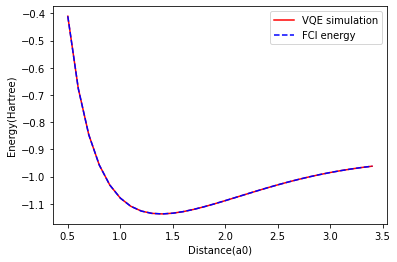

In [8]:
plt.plot(distList, energyList, 'r-', label="VQE simulation")
plt.plot(distList, fciEnergyList, 'b--', label="FCI energy")
plt.xlabel('Distance(a0)')

plt.ylabel('Energy(Hartree)')
plt.legend()
print("time: ", time_end-time_start)

In [9]:
distList = np.arange(0.5,3.5, 0.1)
energyList_1 = np.array([])
print(distList)
params = torch.ones(12, requires_grad=True)
# params = torch.rand(12, requires_grad=True)

time_start=time.time()    


for distance in distList:
    time_epoch_start = time.time()
    circList = []
    compiledCircList = []
    weightList = []
    fciE = initCircuit(distance)
#     params = torch.ones(12, requires_grad=True)
#     params = torch.rand(12, requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=0.9)

    exp = last_exp = 10000
    count = 0
    for epoch in range(200):
        l_sum = 0

        loss = nn.L1Loss()
        x = torch.reshape(params, (4,3))
        psi_star = torch.conj(compiledCircList[0](x))
        exp = 0
        for idx, compiledCirc in enumerate(compiledCircList):   
#             H_psi = compiledCirc(x)
#             exp += torch.tensordot(psi_star[0],H_psi[0], dims=4).real*weightList[idx].real
            exp += compiledCirc(x).real*weightList[idx].real
            pass
        
        if epoch%5==0:
            print(epoch, exp.item())
        if np.abs(exp.item()-last_exp)<tolerance:
            count+=1
            if count>min_pass:
                break
        else:
            count = 0
        if time.time()-time_epoch_start>30:
            break
        last_exp = exp.item()
        l = loss(exp, torch.Tensor([-100.]))
        l.backward()        
        optimizer.step()
        optimizer.zero_grad()
    print(params)
    energyList_1 = np.append(energyList_1, exp.item())
time_end=time.time()

[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4]
Hartree-Fock energy of -0.4033264416010218 Hartree.
Hartree-Fock energy of -0.41078847041741406 Hartree.
0 1.8715239763259888
5 1.6728017330169678
10 1.3911371231079102
15 1.3045921325683594
20 1.1498634815216064
25 -0.0196046382188797
30 -0.17463190853595734
35 -0.22249053418636322
40 -0.31167635321617126
45 -0.3666268587112427
50 -0.3891586363315582
55 -0.40181970596313477
60 -0.4026760458946228
65 -0.39774924516677856
70 -0.4041237235069275
75 -0.4068910479545593
80 -0.40911865234375
85 -0.4097751975059509
90 -0.41046595573425293
95 -0.41008269786834717
100 -0.4105347692966461
105 -0.4106913208961487
110 -0.41069525480270386
115 -0.41072604060173035
120 -0.41075465083122253
125 -0.4107755422592163
130 -0.4107724726200104
135 -0.41078460216522217
140 -0.4107827842235565
145 -0.4107861816883087
150 -0.4107877016067505
tensor([3.2199e+00, 5.0885e-02, 1.0000e+00, 3.

110 -1.13522469997406
115 -1.1352226734161377
120 -1.1352260112762451
125 -1.1352273225784302
130 -1.1352269649505615
tensor([ 3.3136e+00,  1.1172e-01,  1.0000e+00,  3.1419e+00,  3.1419e+00,
         1.0000e+00,  3.1420e+00, -3.9887e-04,  1.0000e+00,  3.1418e+00,
         3.1414e+00,  1.0000e+00], requires_grad=True)
Hartree-Fock energy of -1.1167143250638318 Hartree.
Hartree-Fock energy of -1.1372759436172828 Hartree.
0 -1.1370958089828491
5 -1.0217018127441406
10 -1.063835620880127
15 -1.036151647567749
20 -1.0606281757354736
25 -1.1087939739227295
30 -1.1286284923553467
35 -1.1261415481567383
40 -1.130014181137085
45 -1.1348494291305542
50 -1.1349729299545288
55 -1.1356258392333984
60 -1.1369943618774414
65 -1.1364948749542236
70 -1.1371116638183594
75 -1.1370282173156738
80 -1.137171983718872
85 -1.1372168064117432
90 -1.1372441053390503
95 -1.1372448205947876
100 -1.1372599601745605
105 -1.1372716426849365
110 -1.1372706890106201
115 -1.1372712850570679
120 -1.1372755765914917
125

115 -1.0647387504577637
120 -1.0647385120391846
125 -1.0647377967834473
130 -1.0647388696670532
tensor([ 3.5221e+00,  2.6023e-01,  1.0000e+00,  1.5707e+01, -9.4241e+00,
         1.0000e+00,  3.1414e+00,  1.6330e-04,  1.0000e+00, -1.2566e+01,
         1.8849e+01,  1.0000e+00], requires_grad=True)
Hartree-Fock energy of -0.999643227920801 Hartree.
Hartree-Fock energy of -1.0529584893385886 Hartree.
0 -1.0526418685913086
5 -0.9426240921020508
10 -0.9921164512634277
15 -0.9997777938842773
20 -1.003875732421875
25 -1.0284255743026733
30 -1.0467296838760376
35 -1.0498586893081665
40 -1.0475271940231323
45 -1.0504153966903687
50 -1.0516130924224854
55 -1.0522887706756592
60 -1.052183985710144
65 -1.0528098344802856
70 -1.0526574850082397
75 -1.0528920888900757
80 -1.0528748035430908
85 -1.052922010421753
90 -1.0529237985610962
95 -1.052952527999878
100 -1.052945613861084
105 -1.0529502630233765
110 -1.052956461906433
115 -1.052956223487854
120 -1.0529571771621704
125 -1.0529581308364868
tenso

0 -0.9718297719955444
5 -0.8968297839164734
10 -0.9419910311698914
15 -0.9384912848472595
20 -0.9491252303123474
25 -0.953227698802948
30 -0.9600419402122498
35 -0.9671165943145752
40 -0.9703760743141174
45 -0.971275269985199
50 -0.9706754684448242
55 -0.97112637758255
60 -0.9718985557556152
65 -0.9718376398086548
70 -0.9719724655151367
75 -0.9721031188964844
80 -0.9720492959022522
85 -0.9721255898475647
90 -0.9721190929412842
95 -0.9721444249153137
100 -0.9721360206604004
105 -0.9721461534500122
110 -0.9721434712409973
115 -0.9721459150314331
120 -0.9721466302871704
tensor([ 3.8575e+00,  5.9472e-01,  1.0000e+00,  4.0840e+01, -3.1423e+00,
         1.0000e+00,  3.1425e+00, -9.0315e-04,  1.0000e+00, -2.5134e+01,
         3.1417e+01,  1.0000e+00], requires_grad=True)
Hartree-Fock energy of -0.8422970366437781 Hartree.
Hartree-Fock energy of -0.966692672976077 Hartree.
0 -0.9663931727409363
5 -0.8727685809135437
10 -0.9493661522865295
15 -0.9338483810424805
20 -0.9401050806045532
25 -0.945

In [11]:
np.savez('vqe_tedq.npz', t=timestamp, e=error, d=distList, el=energyList, el1=energyList_1, rel=fciEnergyList)